In [1]:
from src.models.MultiModal import MultiModalModel, MultiModalModel_GB
from torch.utils.data import DataLoader
import os, torch

if(torch.cuda.device_count() >= 1):
    device = "cuda:1"
else:
    device = 'cpu'
    
ts_cols = [
    '\\q95', '\\ipmhd', '\\kappa', '\\tritop', '\\tribot',
    '\\betap','\\betan','\\li', '\\WTOT_DLM03', '\\ne_inter01', 
    '\\TS_NE_CORE_AVG', '\\TS_TE_CORE_AVG'
]

args_video = {
    "image_size" : 128, 
    "patch_size" : 16, 
    "n_frames" : 21, 
    "dim": 128, 
    "depth" : 4, 
    "n_heads" : 8, 
    "pool" : 'cls', 
    "in_channels" : 3, 
    "d_head" : 64, 
    "dropout" : 0.25,
    "embedd_dropout": 0.25, 
    "scale_dim" : 4,
}

args_0D = {
    "n_features" : len(ts_cols), 
    "feature_dims" : 128,
    "max_len" : 21, 
    "n_layers" : 4,
    "n_heads" : 8,
    "dim_feedforward":512, 
    "dropout" : 0.25,
}

model = MultiModalModel(
    2,
    21,
    args_video,
    args_0D
)

model.to(device)

# save_best_dir = "./weights/Multi-Modal_clip_21_dist_5_Focal_RS_RW_best.pt"
# model.load_state_dict(torch.load(save_best_dir))

MultiModalModel(
  (encoder_video): ViViTEncoder(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1=16, p2=16)
      (1): Linear(in_features=768, out_features=128, bias=True)
    )
    (space_transformer): Transformer(
      (layers): ModuleList(
        (0): ModuleList(
          (0): PreNorm(
            (fn): Attention(
              (to_qkv): Linear(in_features=128, out_features=1536, bias=False)
              (to_out): Sequential(
                (0): Linear(in_features=512, out_features=128, bias=True)
                (1): Dropout(p=0.25, inplace=False)
              )
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          )
          (1): PreNorm(
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(in_features=128, out_features=512, bias=True)
                (1): GELU()
                (2): Dropout(p=0.25, inplace=False)
                (3

In [51]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from src.dataset import MultiModalDataset2
from src.utils.sampler import ImbalancedDatasetSampler
from src.utils.utility import preparing_multi_data
from src.models.MultiModal import MultiModalModel
from src.config import Config

config = Config()
ts_cols = config.input_features

# dataset setup
root_dir = "./dataset/temp"
ts_filepath = "./dataset/KSTAR_Disruption_ts_data_5ms.csv"
(shot_train, ts_train), (shot_valid, ts_valid), (shot_test, ts_test), scaler = preparing_multi_data(root_dir, ts_filepath, ts_cols, scaler = 'Robust', test_shot = 21310)
kstar_shot_list = pd.read_csv('./dataset/KSTAR_Disruption_Shot_List_extend.csv', encoding = "euc-kr")

In [52]:
train_data = MultiModalDataset2(shot_train, kstar_shot_list, ts_train, ts_cols, augmentation=True, augmentation_args=None, crop_size=128, seq_len = 21, dist = 3, dt = 1 / 210, scaler = scaler, tau = 4)
valid_data = MultiModalDataset2(shot_valid, kstar_shot_list, ts_valid, ts_cols, augmentation=False, augmentation_args=None, crop_size=128, seq_len = 21, dist = 3, dt = 1 / 210, scaler = scaler, tau = 4)
test_data = MultiModalDataset2(shot_test, kstar_shot_list, ts_test, ts_cols, augmentation=False, augmentation_args=None, crop_size=128, seq_len = 21, dist = 3, dt = 1 / 210, scaler = scaler, tau = 4)

print("================= Dataset information =================")
print("train data : {}, disrupt : {}, non-disrupt : {}".format(train_data.__len__(), train_data.n_disrupt, train_data.n_normal))
print("valid data : {}, disrupt : {}, non-disrupt : {}".format(valid_data.__len__(), valid_data.n_disrupt, valid_data.n_normal))
print("test data : {}, disrupt : {}, non-disrupt : {}".format(test_data.__len__(), test_data.n_disrupt, test_data.n_normal))

# label distribution for LDAM / Focal Loss
train_data.get_num_per_cls()
cls_num_list = train_data.get_cls_num_list()

train_sampler = None
valid_sampler = None
test_sampler = None
    
# Samplers for visualization of embedding space
train_sampler_vis = ImbalancedDatasetSampler(train_data)
test_sampler_vis = ImbalancedDatasetSampler(test_data)

train_loader = DataLoader(train_data, batch_size = 1, sampler=train_sampler, num_workers = 1, pin_memory=False, drop_last = True)
test_loader = DataLoader(test_data, batch_size = 1, sampler=test_sampler, num_workers = 1, pin_memory=False, drop_last = True)

/home/zinzinbin/anaconda3/envs/research-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
extract the null data / short time data: 100%|██████████| 213/213 [00:00<00:00, 365.96it/s]


# check | video data : 8490, 0D data : 8490


/home/zinzinbin/anaconda3/envs/research-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
extract the null data / short time data: 100%|██████████| 53/53 [00:00<00:00, 403.20it/s]


# check | video data : 1962, 0D data : 1962


/home/zinzinbin/anaconda3/envs/research-env/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but RobustScaler was fitted without feature names
  warnings.warn(
extract the null data / short time data: 100%|██████████| 70/70 [00:00<00:00, 410.57it/s]


# check | video data : 2561, 0D data : 2561
================= Dataset information =================
train data : 8490, disrupt : 140, non-disrupt : 8350
valid data : 1962, disrupt : 42, non-disrupt : 1920
test data : 2561, disrupt : 45, non-disrupt : 2516


In [53]:
from tqdm.auto import tqdm

for idx, (sample_data, sample_target) in enumerate(tqdm(train_loader)):
    if sample_target == 0:
        break

sample_video = sample_data['video']
sample_0D = sample_data['0D']

  0%|          | 0/8490 [00:00<?, ?it/s]

In [54]:
sample_target

tensor([0])

In [55]:
sample_video = sample_video.squeeze(0).permute(1,2,3,0).numpy()

In [56]:
sample_0D = sample_0D.squeeze(0).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


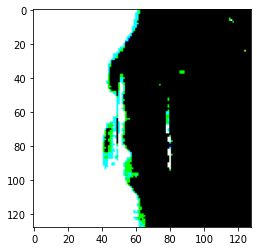

In [60]:
import matplotlib.pyplot as plt
plt.imshow(sample_video[-1,:,:,:])

Text(0, 0.5, 'parameters')

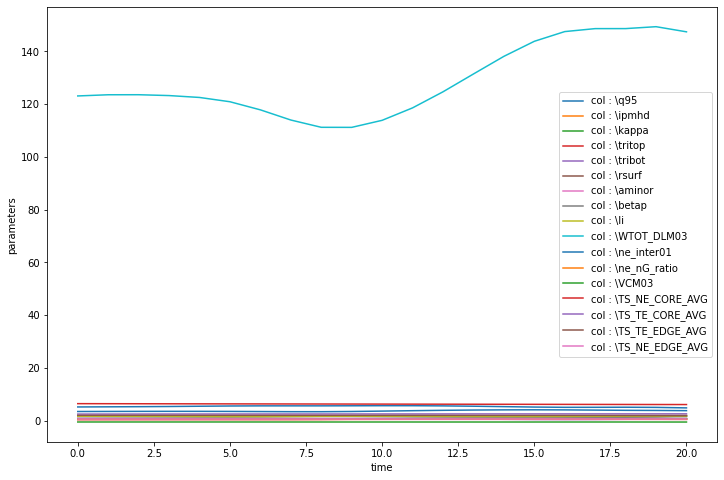

In [58]:
plt.figure(figsize = (12,8))

sample_0D = scaler.inverse_transform(sample_0D)
for idx in range(len(ts_cols)):
    plt.plot(sample_0D[:,idx], label = "col : {}".format(ts_cols[idx]))

plt.legend()
plt.xlabel("time")
plt.ylabel("parameters")

/home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /home/jinsukim/miniconda3/envs/research-env/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")



################# Probability curve generation process #################



/home/jinsukim/codes_for_study/research-predict-disruption/src/utils/utility.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_data[ts_cols] = self.scaler.fit_transform(self.ts_data[ts_cols].values)
100%|██████████| 795/795 [00:43<00:00, 18.09it/s]


time :  1365
prob :  1365
thermal quench :  5.342
current quench:  5.368


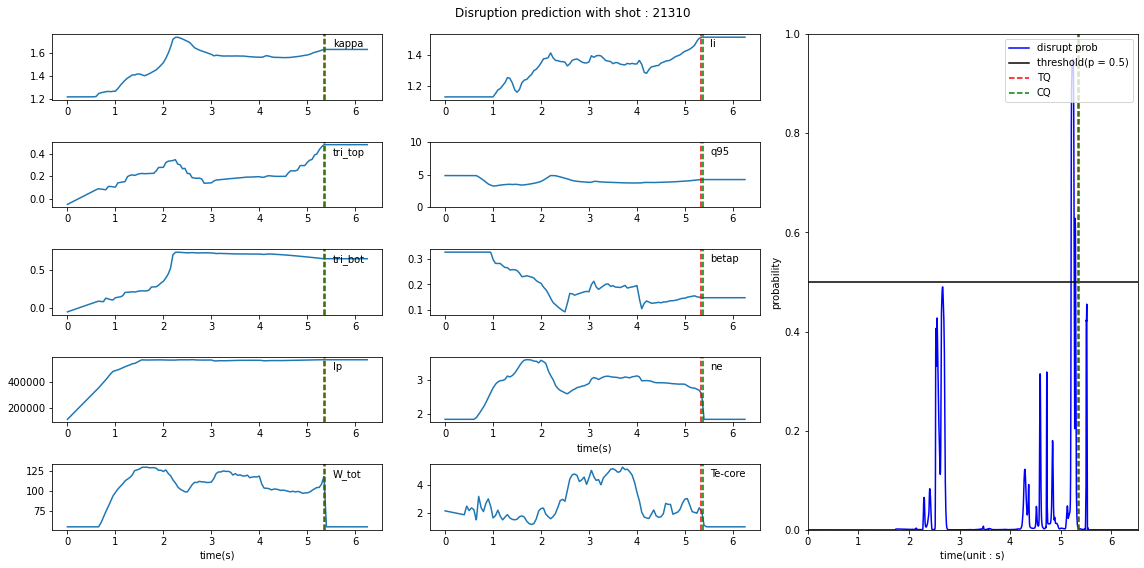

In [2]:
from src.utils.utility import generate_prob_curve_from_multi, MultiModalDataset, measure_computation_time_multi

test_shot_num = 21310
print("\n################# Probability curve generation process #################\n")
time_x, prob_list = generate_prob_curve_from_multi(
    file_path = "./dataset/temp/{}".format(test_shot_num),
    model = model,
    device = device,
    save_dir = "./results/Multi-Modal_clip_21_dist_5_Focal_RS_RW_probs_curve.png",
    ts_data_dir = "./dataset/KSTAR_Disruption_ts_data_5ms.csv",
    ts_cols = ts_cols,
    shot_num = test_shot_num,
    vis_seq_len = 21,
    ts_seq_len = 21,
    dist = 5,
    dt = 1 / 210,
    scaler = None
)

In [ ]:
from src.utils.utility import measure_computation_time_multi
t_avg, t_std, t_measures = measure_computation_time_multi(model, input_shape_vis = (1, 3, 21, 128, 128), input_shape_0D = (1,21,12), n_samples = 16, device = device)

print("t_avg : {:.3f}, t_std : {:.3f}".format(t_avg, t_std))

In [3]:
import pandas as pd

ts_data = pd.read_csv("./dataset/KSTAR_Disruption_ts_data_5ms.csv")
ts_data.head()

,time,shot,\q95,\ipmhd,\kappa,\tritop,\tribot,\betap,\betan,\li,...,\TS_EDGE11:EDGE11_NE,\TS_EDGE12:EDGE12_NE,\TS_EDGE13:EDGE13_NE,\TS_EDGE14:EDGE14_NE,\TS_EDGE15:EDGE15_NE,\TS_NE_CORE_AVG,\TS_NE_EDGE_AVG,\TS_TE_CORE_AVG,\TS_TE_EDGE_AVG,frame_idx
0,0.000000,13074,6.415995,19338.836011,1.282146,0.523962,-0.057457,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.066000,0.646001,0.841420,0.096789,0
1,0.004762,13074,6.415995,21811.813093,1.282146,0.523962,-0.055073,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.069713,0.642311,0.846794,0.097835,1
2,0.009524,13074,6.415995,24284.790175,1.282146,0.523962,-0.052688,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.073425,0.638621,0.852169,0.098881,2
3,0.014286,13074,6.415995,26757.767257,1.282146,0.523962,-0.050304,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.077138,0.634930,0.857543,0.099926,3
4,0.019048,13074,6.415995,29230.744339,1.282146,0.523962,-0.047919,1.026884,1.17876,1.479425,...,0.0,0.0,0.0,0.0,0.0,0.080850,0.631240,0.862918,0.100972,4



################# Probability curve generation process #################



/home/jinsukim/codes_for_study/research-predict-disruption/src/utils/utility.py:538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_data[ts_cols] = self.scaler.fit_transform(self.ts_data[ts_cols].values)
100%|██████████| 795/795 [00:42<00:00, 18.88it/s]


time :  1368
prob :  1368
thermal quench :  5.342
current quench:  5.368


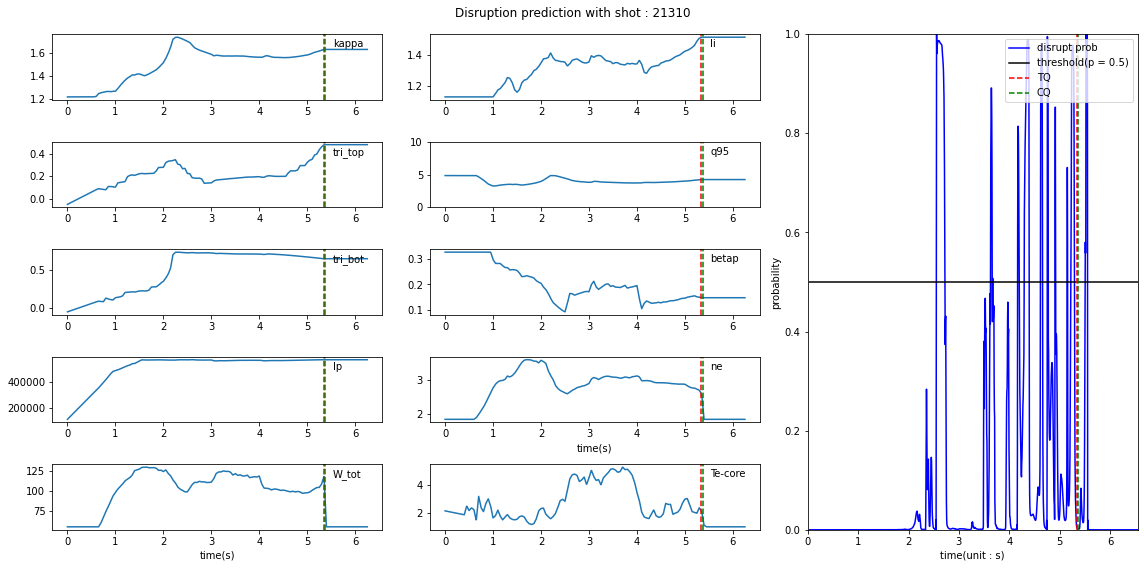

In [6]:
from src.utils.utility import generate_prob_curve_from_multi, MultiModalDataset

model = MultiModalModel(
    2,
    21,
    args_video,
    args_0D
)

save_best_dir = "./weights/Multi-Modal_clip_21_dist_8_Focal_RS_RW_best.pt"
model.load_state_dict(torch.load(save_best_dir))

test_shot_num = 21310
print("\n################# Probability curve generation process #################\n")
time_x, prob_list = generate_prob_curve_from_multi(
    file_path = "./dataset/temp/{}".format(test_shot_num),
    model = model,
    device = device,
    save_dir = "./results/Multi-Modal_clip_21_dist_8_Focal_RS_RW_probs_curve.png",
    ts_data_dir = "./dataset/KSTAR_Disruption_ts_data_5ms.csv",
    ts_cols = ts_cols,
    shot_num = test_shot_num,
    vis_seq_len = 21,
    ts_seq_len = 21,
    dist = 8,
    dt = 1 / 210,
    scaler = None
)


################# Probability curve generation process #################



/home/jinsukim/codes_for_study/research-predict-disruption/src/utils/utility.py:464: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ts_data[cols] = self.scaler.fit_transform(self.ts_data[cols].values)
100%|██████████| 307/307 [00:01<00:00, 272.42it/s]


time :  1312
prob :  1312
thermal quench :  5.342
current quench:  5.368


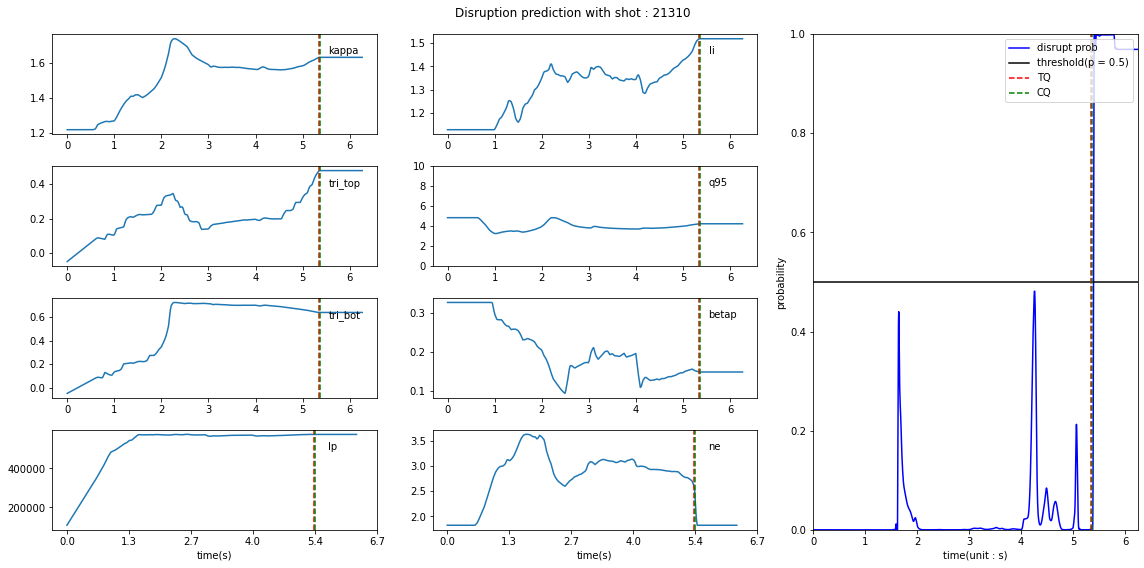

In [2]:
# compare with 0D data only
from src.utils.utility import generate_prob_curve_from_0D, DatasetFor0D
from src.models.transformer import Transformer
from src.config import Config
from torch.utils.data import DataLoader
import os, torch

if(torch.cuda.device_count() >= 1):
    device = "cuda:0"
else:
    device = 'cpu'

config = Config()    
ts_cols = config.input_features

model = Transformer(
    n_features=len(ts_cols),
    feature_dims = 128,
    max_len = 21,
    n_layers = 4,
    n_heads = 8,
    dim_feedforward=512,
    dropout = 0.25,
    cls_dims = 128,
    n_classes = 2
)

save_best_dir = "./weights/Transformer_clip_21_dist_2_Focal_RS_RW_best.pt"
model.load_state_dict(torch.load(save_best_dir))

test_shot_num = 21310
print("\n################# Probability curve generation process #################\n")
time_x, prob_list = generate_prob_curve_from_0D(
    model,
    device,
    "./results/disruption_probs_curve.png",
    ts_data_dir = "./dataset/KSTAR_Disruption_ts_data_extend.csv",
    ts_cols = ts_cols,
    shot_list_dir = './dataset/KSTAR_Disruption_Shot_List_extend.csv',
    shot_num = test_shot_num,
    seq_len = 21,
    dist = 2,
    dt = 1/210 * 4,
    scaler = None,
)